## Optimization:
- Change value of momentum 
- Batch normalization 
- Weight initialization 
- Number of parameters 
- Knowledge Distilation
- Dropout (Regularization)
- Tune hyperparameters 

Sources:
- https://towardsdatascience.com/how-to-optimize-a-deep-learning-model-2e9ff8a4c5de
- https://www.cs.toronto.edu/~lczhang/321/tut/tut06.html

### Parameters
- https://towardsdatascience.com/how-to-reduce-training-parameters-in-cnns-while-keeping-accuracy-99-a213034a9777

### Batch normalization 
- https://discuss.pytorch.org/t/loss-doesnt-decrease-while-training/83751/5


### Weight Initialization 
- https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78


Hint from Nhan:
- "He" initialization 
- Validation (dont train)?
- Test validation set 

### Knowledge Distilation 
- https://josehoras.github.io/knowledge-distillation/
- https://github.com/haitongli/knowledge-distillation-pytorch

In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os 
import cv2
import pandas as pd 
import random 
import os, os.path
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchinfo import summary
import imutils


#use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#labels  
LABELS_DICT = {
    '0' : 0,
    '1' : 1,
    '2' : 2,
    '3' : 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    'plus' : 10,
    'minus' : 11,
    'slash' : 12,
    'dot' : 13,
    'w' : 14,
    'x' : 15,
    'y' : 16,
    'z' : 17,
    }

INV_LABELS_DICS = {v: k for k, v in LABELS_DICT.items()}

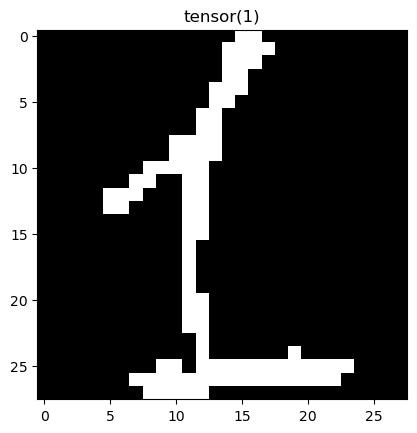

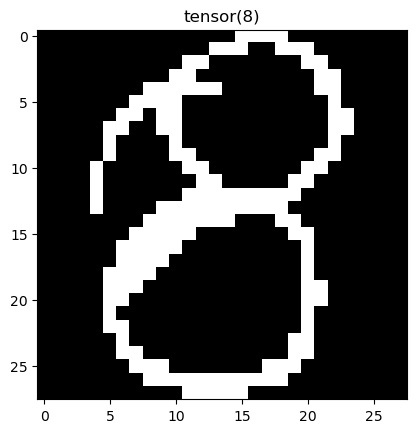

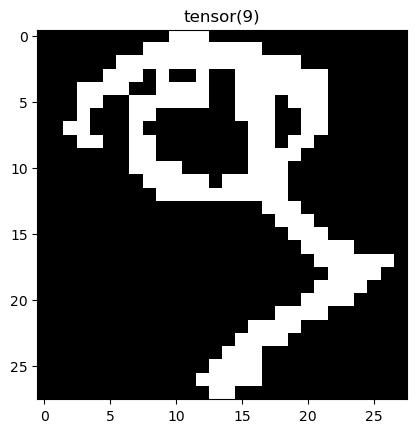

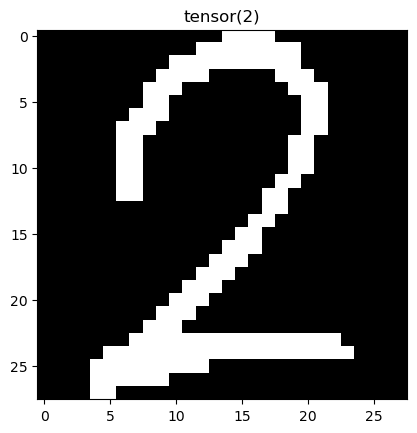

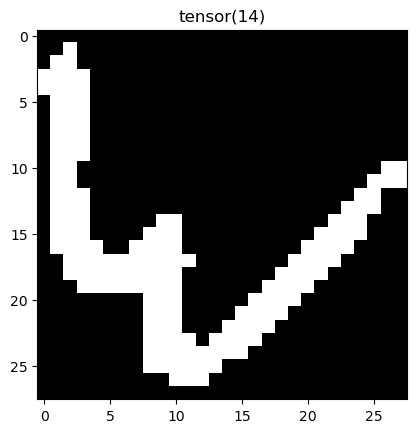

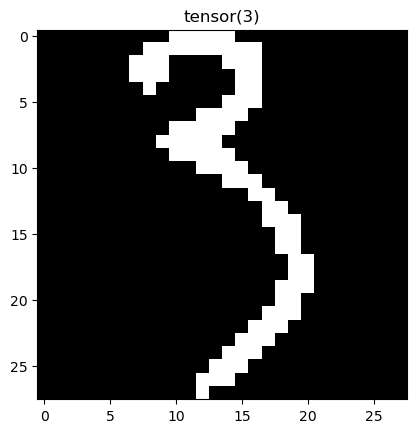

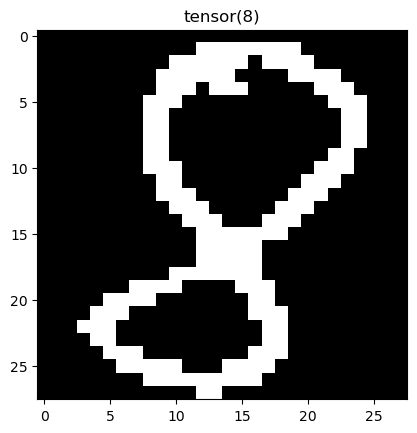

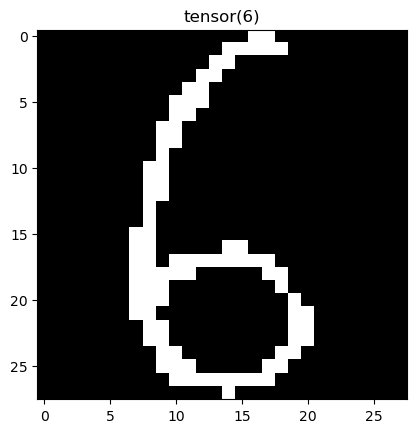

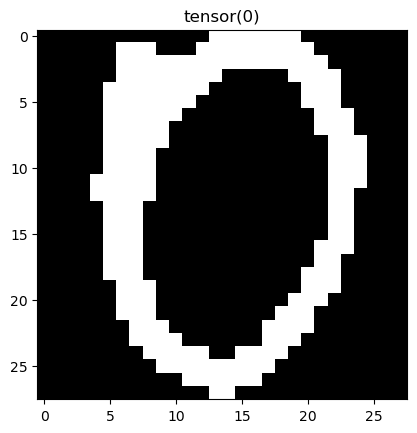

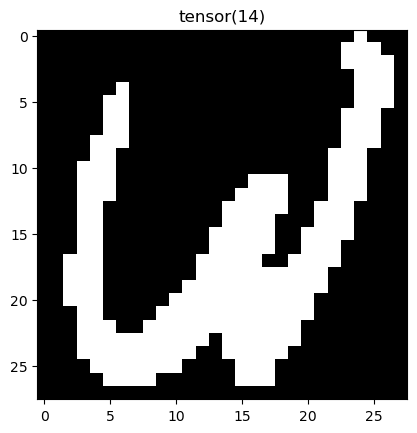

In [2]:
"""
CREATING CUSTOM DATASET
Data consist of: 
- Numbers from 1-9
- Operators: +, -, / and * 
- Letters: w, x, y, z

- Format of each image: <symbol-name>-<id>.png
- 1500 images of each type 
"""

class Digits(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    #function to resize image to same dimensions 
    def convert(self, img_path):
        image = cv2.imread(img_path)
        #image = cv2.resize(image, (32, 32))      
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converting from bgr to grayscale for faster computation 
        _ , image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        if self.transform:
            image = self.transform(image) 

            """
            print("Normal:", torch.mean(image))
            print("Normal:", torch.std(image))
            print("Normal:",torch.var(image))
            """

            #normalizing tensor
            mean, std = torch.mean(image), torch.std(image)
            normalize = transforms.Normalize(mean, std)
            image = normalize(image)

            """       
            print("Normalised:", torch.mean(image))
            print("Normalised:", torch.std(image))
            print("Normalised:",torch.var(image))
            """
        return image

    #function to get image label
    def get_label(self, filename):
        label_name = filename.split("-")
        label = LABELS_DICT[label_name[0]]

        if self.target_transform:
            label = self.target_transform(label)
        
        return label

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        #getting image path
        filename = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, filename)
        
        #get image and corresponding label
        label = self.get_label(filename)
        image = self.convert(img_path)
        
        return image, label
    


#set up dataset
transform = transforms.Compose([transforms.ToTensor()]) #normalizing data
#target_transform = transforms.Compose([lambda x: torch.tensor([x]), 
#                                        lambda x: torch.nn.functional.one_hot(x, num_classes=len(LABELS_DICT))]) 

dataset = Digits("data/symbols/", transform=transform)

datasetSize = dataset.__len__()
batch_size = 2 

#split data: 80% training, 10% validation, 10% test
test_train_data, test_validation_data, test_test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])

#creating data loaders
test_trainloader = DataLoader(test_train_data, batch_size=batch_size, shuffle=True, num_workers=0)


"""
GETTING SOME IMAGES FROM DATASET 
"""
dataiter = iter(test_trainloader)
images, labels = dataiter.next()

#run through 3 batches
for i in range(5): #Run through 5 batches
    images, labels = dataiter.next()
    for image, label in zip(images, labels): # Run through all samples in a batch
        plt.figure()
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)), cmap="gray")
        plt.title(label)


In [3]:
"""
PREPARING DATA FOR TRAINING
"""
#normalizing data and one-hot encode
transform = transforms.Compose([transforms.ToTensor()])  

#create data
dataset = Digits("data/symbols/", transform=transform)
datasetSize = dataset.__len__()

batch_size = 64 

#split data: 80% training, 10% validation, 10% test
train_data, validation_data, test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])
#train_data, validation_data, test_data = random_split(dataset, [6500, 500, 20000])

#creating data loaders
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
validateloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

In [5]:
"""
NETWORK

CNN network 
Hyperparameters:
- Kernel size
- Pooling size
- Number of filters/layers
- Epochs 
- Dropout
- Number of neurons 
- Connectivity between patterns 
- Batch size
- Learning rate

Source: https://www.researchgate.net/figure/List-of-key-hyperparameters-related-to-CNN-design_tbl1_333159463

"""
class Network(nn.Module):
    def __init__(self, num_classes):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same', bias=True)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding="same", bias=True)
        self.batch2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding="same", bias=True)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.conv2_drop = nn.Dropout2d() #dropout (type of regularization) avoids overfitting
        self.fc1 = nn.Linear(64 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    
    def forward(self, x):
        x = self.conv1(x)   #[batch size, 32, 28, 28]
        x = self.pool1(x)   #[batch size, 32, 14, 14]
        x = F.relu(x)
        x = self.conv2(x)   #[batch size, 32, 28, 28]
        x = self.pool2(x)   #[batch size, 32, 7, 7]
        x = F.relu(x)
        x = self.conv3(x)   #[batch size, 64, 7, 7]
        x = self.pool3(x)   #[batch size, 64, 3, 3]
        x = F.relu(x)
        x = self.flatten(x) #[batch size, 64 * 3 * 3]
        x = self.conv2_drop(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


#testing forward call 
testNetwork = Network(len(LABELS_DICT)).to(device)
print(summary(testNetwork, (1, 1, 28, 28)))

"""
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

print(len(example_data))
print(example_data.shape)
"""

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 18]                   128
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 32, 14, 14]           9,248
├─MaxPool2d: 1-4                         [1, 32, 7, 7]             --
├─Conv2d: 1-5                            [1, 64, 7, 7]             18,496
├─MaxPool2d: 1-6                         [1, 64, 3, 3]             --
├─Flatten: 1-7                           [1, 576]                  --
├─Dropout2d: 1-8                         [1, 576]                  --
├─Linear: 1-9                            [1, 120]                  69,240
├─Linear: 1-10                           [1, 84]                   10,164
├─Linear: 1-11                           [1, 18]                   1,530
Total params: 109,126
Trainable params: 109,126
Non-trainable par

c:\Users\emilh\anaconda3\envs\dl\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


'\nexamples = enumerate(trainloader)\nbatch_idx, (example_data, example_targets) = next(examples)\n\nprint(len(example_data))\nprint(example_data.shape)\n'

## Notes

#### Loss 
- Does validation loss converge? If not, adjust number of epochs or learning rate / optimizer
- Is validation loss too high? Consider more regularization if so.

### Grid search
- A common way to scan for good hyperparameter values is a ‘grid search’, in which multiple parameters are varied simultaneously

### Batch
-  Generally, small batch sizes will need fewer epochs to converge.

## Questions 
- When/How to initialize weights? (torch.nn.init.xavier_uniform(conv1.weight)
- Where to apply batch normalization?